In [25]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Graph creation
After collecting and pre-processing the data, the graphs are created to build a network between the stocks, using their sectors and correlation.

## Grouping by sector
The first step is to create a graph of the stocks linking every stock that belong to the same activity sector.

In [63]:
stocks = pd.read_csv('./archive/sp500_companies.csv').set_index('Symbol')
stocks.head()

,Exchange,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
Symbol,,,,,,,,,,,,,,,
AAPL,NMS,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,254.49,3846819807232,1.346610e+11,0.061,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.069209
NVDA,NMS,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,134.70,3298803056640,6.118400e+10,1.224,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.059350
MSFT,NMS,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,436.60,3246068596736,1.365520e+11,0.160,Redmond,WA,United States,228000.0,Microsoft Corporation develops and supports so...,0.058401
AMZN,NMS,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,224.92,2365033807872,1.115830e+11,0.110,Seattle,WA,United States,1551000.0,"Amazon.com, Inc. engages in the retail sale of...",0.042550
GOOGL,NMS,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,191.41,2351625142272,1.234700e+11,0.151,Mountain View,CA,United States,181269.0,Alphabet Inc. offers various products and plat...,0.042309


In [27]:
adj_stocks = np.array([
	[stocks.loc[stock1, 'Sector'] == stocks.loc[stock2, 'Sector'] * (stock1 != stock2) for stock1 in stocks.index] for stock2 in stocks.index
]).astype(int)

In [37]:
np.save('./data/raw/adj_sector.npy', adj_stocks)

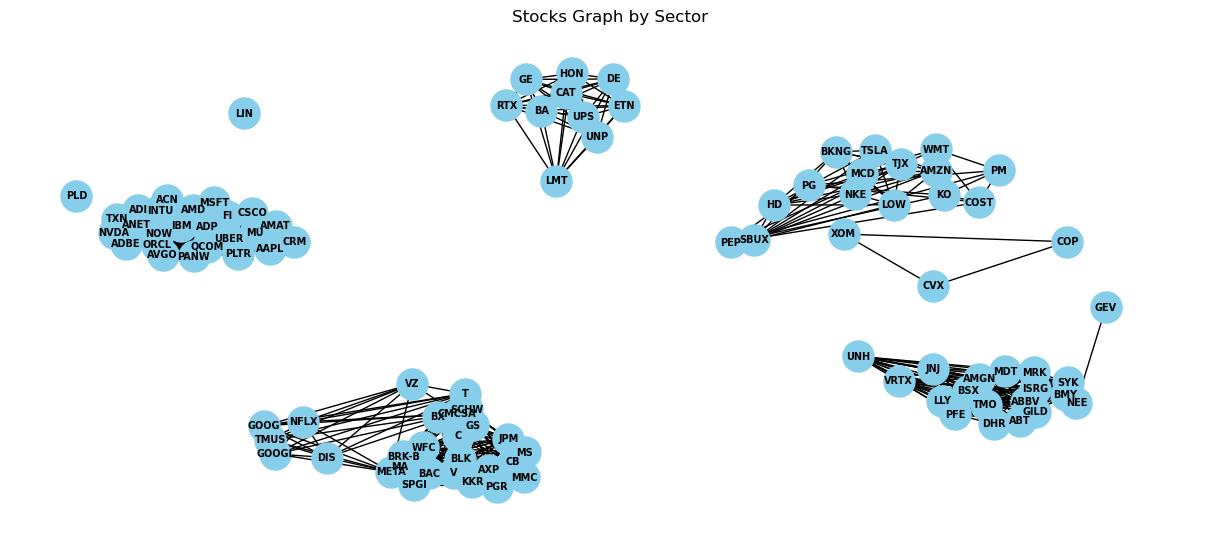

In [28]:
stocks_graph = nx.from_numpy_array(adj_stocks[:100, :100])
stocks_graph = nx.relabel_nodes(stocks_graph, dict(enumerate(stocks.index)))
plt.figure(figsize=(12, 5))
nx.draw(stocks_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=7, font_weight='bold', font_color='black', pos=nx.spring_layout(stocks_graph, k=.5))
plt.title('Stocks Graph by Sector')
plt.show()

## Graph by fundamentals correlation
A great way to link the stocks would be using their fundamental data, such as market capitalization, p/e ratio, etc. An autoencoder is built to reduce the dimensionality of the fundamental data, and the stocks are clustered and linked following these clusters. Furthermore, the correlation between the fundamental data is used to link the stocks that have a high correlation.

In [29]:
fundamentals = pd.read_csv('./data/raw/fundamentals.csv').set_index("Symbol")
fundamentals.head(n=10)

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,8.791352,-0.013172,0.213950,0.542696,-0.036933,-0.093747,-0.046419,-0.097920,0.266318,-0.826169,0.443785,3.575526,0.624976,0.945694
NVDA,11.216640,0.235196,0.686894,0.507106,-0.207299,-0.249041,-0.046462,-0.112094,2.663816,-1.131405,1.119990,12.791693,3.296692,2.767908
MSFT,8.487851,-0.006110,0.272476,0.115368,0.247869,0.152351,-0.044303,-0.086676,0.100892,-0.650821,0.581956,1.077025,1.087700,1.573989
AMZN,5.911475,-0.015220,0.450573,0.083384,-0.053282,-0.173803,-0.044991,-0.113384,0.702015,-1.170371,0.484192,2.909712,-0.167995,-0.187124
GOOGL,7.537973,-0.099724,0.195085,0.098311,0.077504,-0.069656,-0.045114,-0.104232,0.047304,-1.170371,1.716401,2.045545,0.479521,1.325730
GOOG,7.531482,-0.099298,0.197209,0.098435,0.077504,-0.070027,-0.045114,-0.104232,0.047304,-1.170371,1.680884,1.159353,0.482090,1.325730
META,3.379656,-0.098169,0.023819,0.092659,0.615704,0.535953,-0.042945,-0.102999,0.520280,-1.170371,0.223370,0.535121,0.479251,1.229899
TSLA,3.266195,3.055852,3.188441,0.202984,-0.295063,-0.281657,-0.045499,-0.113384,2.577609,-1.170371,2.170007,5.993022,1.416595,-0.597960
AVGO,3.618974,0.594968,0.913505,0.071331,-0.189230,-0.173062,-0.043802,-0.046676,0.531930,0.219424,3.244884,1.262036,-0.282494,1.279923


In [30]:
def get_clusters(data: np.ndarray, n_clusters: int) -> np.ndarray:
    kmeans = KMeans(n_clusters=n_clusters)
    return kmeans.fit(data).labels_

In [31]:
fundamentals_corr = fundamentals.transpose().corr(method="spearman")
fundamentals_corr = (fundamentals_corr - (fundamentals_corr == 1))  # Remove self-correlation
fundamentals_corr.head(n=10)

Symbol,AAPL,NVDA,MSFT,AMZN,GOOGL,GOOG,META,TSLA,AVGO,BRK-B,...,MOS,NaN,MHK,CE,HII,CZR,BWA,QRVO,FMC,AMTM
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000000,0.938462,0.854945,0.556044,0.916484,0.894505,0.635165,0.578022,0.551648,0.094505,...,-0.283516,-0.081319,-0.200000,-0.367033,-0.578022,0.195604,-0.301099,-0.094505,-0.450549,-0.010989
NVDA,0.938462,0.000000,0.771429,0.600000,0.854945,0.819780,0.498901,0.683516,0.551648,-0.063736,...,-0.257143,-0.200000,-0.239560,-0.314286,-0.714286,0.314286,-0.265934,-0.032967,-0.446154,-0.085714
MSFT,0.854945,0.771429,0.000000,0.318681,0.920879,0.925275,0.797802,0.375824,0.424176,0.279121,...,-0.626374,-0.129670,-0.340659,-0.639560,-0.397802,-0.120879,-0.573626,-0.345055,-0.621978,-0.182418
AMZN,0.556044,0.600000,0.318681,0.000000,0.569231,0.512088,0.235165,0.881319,0.560440,0.134066,...,0.257143,0.213187,0.208791,0.028571,-0.239560,0.507692,0.301099,0.503297,-0.243956,0.252747
GOOGL,0.916484,0.854945,0.920879,0.569231,0.000000,0.986813,0.679121,0.534066,0.564835,0.287912,...,-0.340659,0.024176,-0.305495,-0.520879,-0.336264,0.059341,-0.371429,-0.173626,-0.560440,-0.090110
GOOG,0.894505,0.819780,0.925275,0.512088,0.986813,0.000000,0.679121,0.459341,0.578022,0.327473,...,-0.380220,0.032967,-0.327473,-0.569231,-0.301099,-0.037363,-0.349451,-0.156044,-0.626374,-0.138462
META,0.635165,0.498901,0.797802,0.235165,0.679121,0.679121,0.000000,0.120879,0.221978,0.481319,...,-0.340659,-0.116484,0.081319,-0.358242,-0.340659,-0.024176,-0.481319,-0.257143,-0.481319,-0.230769
TSLA,0.578022,0.683516,0.375824,0.881319,0.534066,0.459341,0.120879,0.000000,0.498901,-0.098901,...,-0.059341,0.032967,0.046154,-0.063736,-0.419780,0.485714,0.142857,0.397802,-0.230769,0.292308
AVGO,0.551648,0.551648,0.424176,0.560440,0.564835,0.578022,0.221978,0.498901,0.000000,0.107692,...,-0.081319,-0.107692,-0.406593,-0.261538,-0.208791,-0.098901,0.116484,0.107692,-0.375824,-0.094505


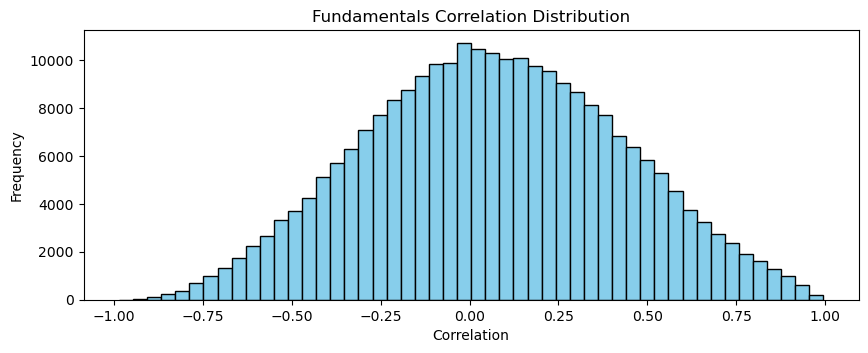

In [32]:
plt.figure(figsize=(10, 3.5))
plt.hist(fundamentals_corr.values.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Fundamentals Correlation Distribution')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.show()

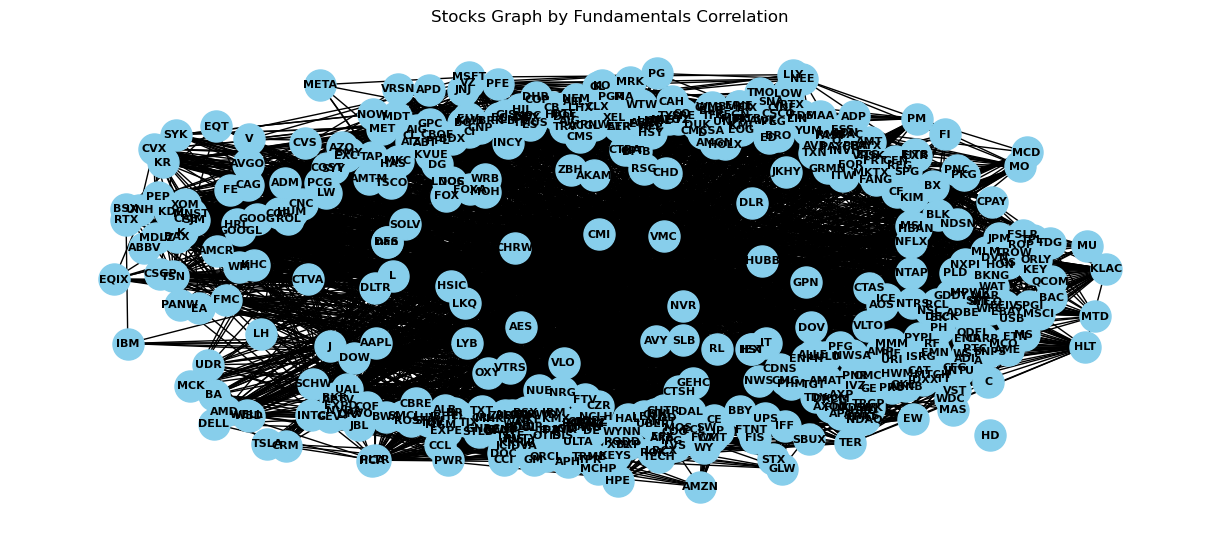

In [33]:
fundamentals_corr_np = fundamentals_corr.to_numpy()
adj_fundamentals_corr = (fundamentals_corr_np * (abs(fundamentals_corr_np) > .7).astype(int))

fundamentals_corr_graph = nx.from_numpy_array(adj_fundamentals_corr)
fundamentals_corr_graph = nx.relabel_nodes(fundamentals_corr_graph, dict(enumerate(fundamentals_corr.index)))

plt.figure(figsize=(12, 5))
nx.draw(fundamentals_corr_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(fundamentals_corr_graph))
plt.title('Stocks Graph by Fundamentals Correlation')
plt.show()

## Merging the graphs
To make use of the two graphs to build the final adjacency matrix. A correlation bonus is given to two stocks sharing the same sector.

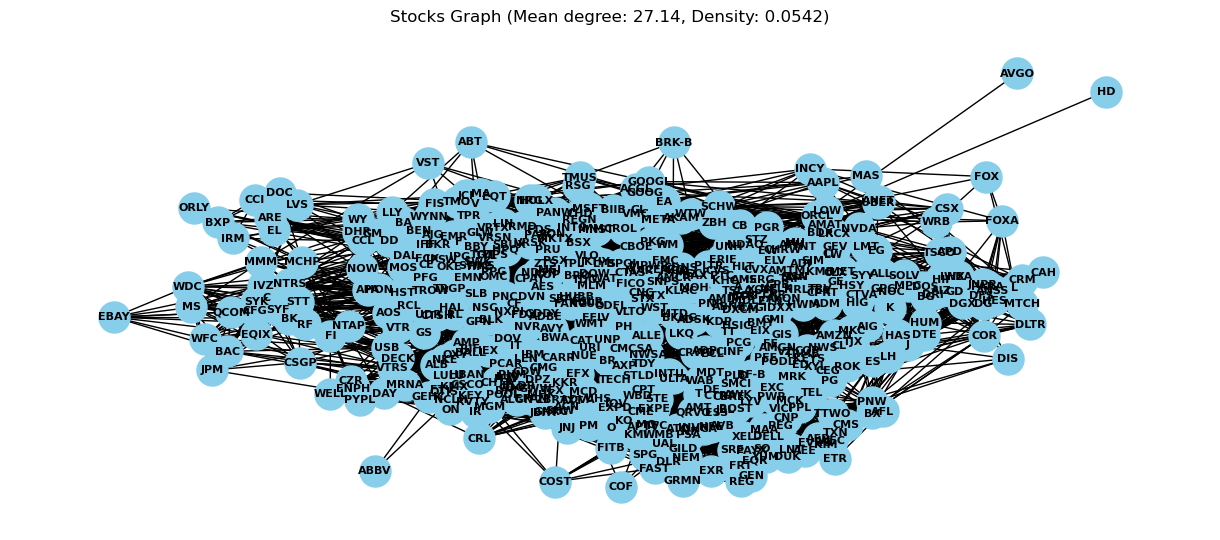

In [34]:
corr_threshold, sector_bonus = .7, .05

share_sector = pd.get_dummies(stocks[["Sector"]]).transpose().corr().to_numpy().astype(int) - np.eye(len(stocks), dtype=int)
# abs because GCNConv only accepts positive weights
adj = abs(fundamentals_corr_np) + share_sector * sector_bonus
adj = adj * (abs(adj) > corr_threshold)  
adj = adj / adj.max()

graph = nx.from_numpy_array(adj)
graph = nx.relabel_nodes(graph, dict(enumerate(stocks.index)))

plt.figure(figsize=(12, 5))
nx.draw(graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(graph, k=.5))
plt.title(f'Stocks Graph (Mean degree: {np.mean([degree for node, degree in graph.degree]):.2f}, Density: {nx.density(graph):.4f})')
plt.show()

In [40]:
weekly_returns = pd.read_csv('./data/raw/weekly_returns.csv').set_index('Date')
weekly_returns.head(n=10)

,AAPL,NVDA,MSFT,AMZN,GOOGL,GOOG,META,TSLA,AVGO,BRK-B,...,IVZ,APA,MOS,MHK,CE,HII,CZR,BWA,QRVO,FMC
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-10 00:00:00-05:00,-0.123687,0.242429,-0.378853,-0.477075,0.613705,0.750923,-0.343752,2.581391,0.320071,0.381205,...,1.317173,2.149616,2.580269,0.360667,0.846640,-0.200051,0.836499,0.962620,1.348889,0.789427
2021-01-17 00:00:00-05:00,-0.969367,-0.459599,-0.964454,-0.516445,-0.960328,-0.968183,-1.038995,-0.738374,0.008553,-0.094969,...,1.360636,0.563075,1.114673,0.679778,-0.331963,0.341542,0.213534,-0.986460,-0.209972,-0.129378
2021-01-24 00:00:00-05:00,1.940776,0.547981,1.762202,1.062382,2.152232,2.135243,1.846799,0.022668,0.512608,-0.369001,...,0.660996,-1.548578,-0.336283,-0.274163,-0.753000,-0.630235,0.245502,1.788912,-0.319325,-0.932642
2021-01-31 00:00:00-05:00,-1.342540,-0.779353,0.785023,-0.547918,-0.845156,-0.844229,-1.009374,-0.757407,-0.575749,-0.901156,...,-0.356038,-1.894703,-1.474842,-0.790944,-1.197858,-1.550996,-1.724866,-0.439842,-0.987736,-0.837837
2021-02-07 00:00:00-05:00,0.952229,0.651250,1.291844,0.921149,3.223903,3.224850,0.617166,0.834346,0.614348,1.294639,...,1.254165,1.759148,1.064699,1.133028,0.680250,0.999671,2.307805,0.600643,-0.392746,0.934123
2021-02-14 00:00:00-05:00,-0.261343,1.382555,0.342511,-0.464696,0.071447,0.070226,0.148163,-0.506172,0.774262,1.256806,...,0.753557,1.033133,0.961185,1.960167,0.770747,1.758523,-0.457366,-0.600643,0.916692,-1.019671
2021-02-21 00:00:00-05:00,-1.015720,-0.309313,-0.364878,-0.077726,0.000692,0.060416,-0.551990,-0.445699,0.433727,0.356820,...,0.030355,0.820930,0.729578,1.382877,0.586811,1.608090,0.820168,0.383686,0.475244,-0.704234
2021-02-28 00:00:00-05:00,-1.754885,-1.218887,-1.085492,-1.024402,-0.784737,-0.750338,-0.252339,-1.701145,-0.759881,-0.228419,...,-0.043374,1.251965,0.184751,0.334959,0.441807,-0.700549,1.646734,0.835619,-0.467117,-0.521092
2021-03-07 00:00:00-05:00,0.033732,-1.379011,-0.100544,-0.628093,0.879877,0.835241,0.424337,-1.425701,-0.778573,2.105755,...,1.130199,2.267066,0.407447,1.158315,1.024621,1.311580,-0.019671,1.885096,-0.339423,0.151142


In [52]:
wr_corr = weekly_returns.corr(method="spearman")
wr_corr = wr_corr - (wr_corr == 1)

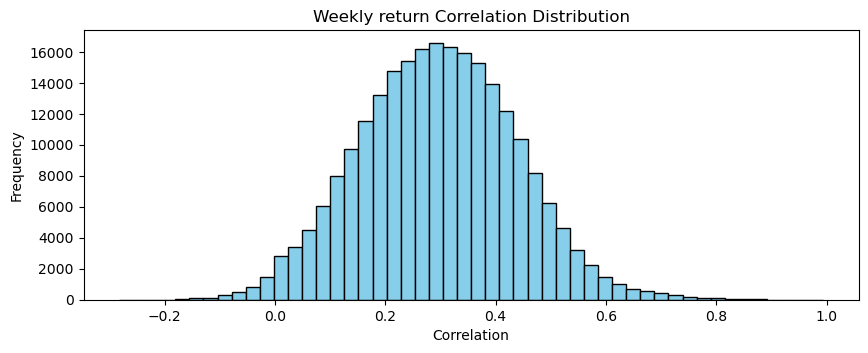

In [64]:
plt.figure(figsize=(10, 3.5))
plt.hist(wr_corr.values.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Weekly return Correlation Distribution')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.show()

In [62]:
wr_corr['MNST']['WMT']

np.float64(0.3339046551987326)

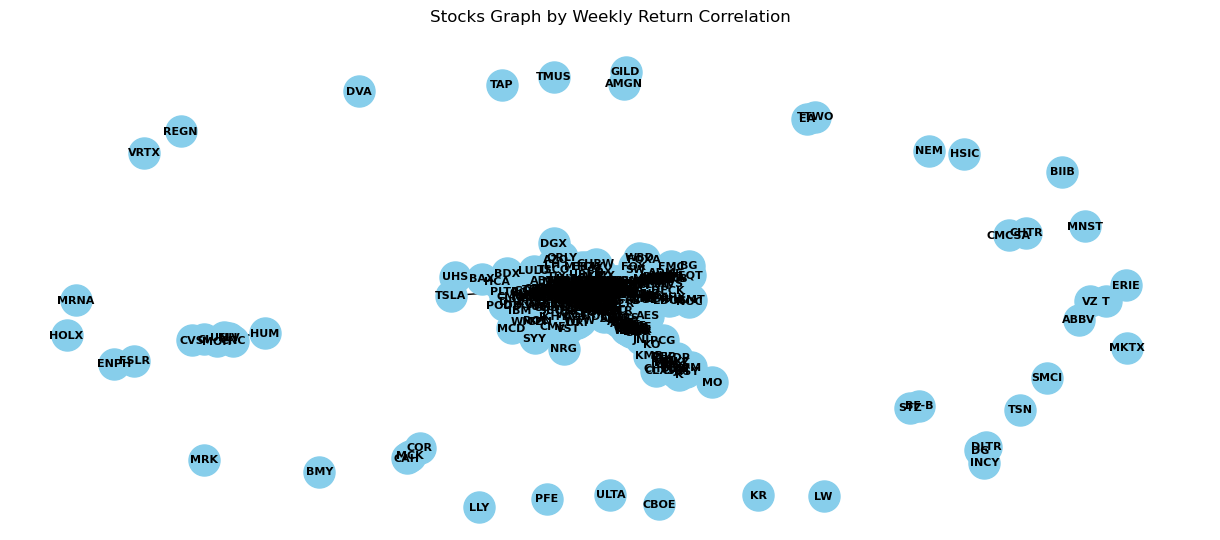

In [65]:
wr_corr_np = wr_corr.to_numpy()
adj_wr_corr = (wr_corr_np * (abs(wr_corr_np) > .5).astype(int))

wr_corr_graph = nx.from_numpy_array(adj_wr_corr)
wr_corr_graph = nx.relabel_nodes(wr_corr_graph, dict(enumerate(wr_corr.index)))

plt.figure(figsize=(12, 5))
nx.draw(wr_corr_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(wr_corr_graph))
plt.title('Stocks Graph by Weekly Return Correlation')
plt.show()

In [57]:
print(f'Stocks Graph (Mean degree: {np.mean([degree for node, degree in wr_corr_graph.degree]):.2f}, Density: {nx.density(wr_corr_graph):.4f})')

Stocks Graph (Mean degree: 35.06, Density: 0.0719)


In [50]:
stocks_names = weekly_returns.columns
stocks_with_return = stocks.loc[stocks_names]
adj_stocks = np.array([
	[stocks.loc[stock1, 'Sector'] == stocks.loc[stock2, 'Sector'] * (stock1 != stock2) for stock1 in stocks.index] for stock2 in stocks.index
]).astype(int)
np.save('./data/raw/adj_sector.npy', adj_stocks)

In [36]:
np.save('./data/raw/adj.npy', adj)